In [1]:
# Graph Theory Homework 2
# Author: Alperen Kantarcı
# Id: 504191504

In [2]:
# Import required modules
# Please note that to run the notebook you should install the requirements via pip or anaconda
# Required modules can be found as requirements.txt in the same folder
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import scipy.io # To read matlab file
import copy
from skimage.future import graph
from skimage import segmentation, color, data
%matplotlib inline

# Question 1

#### Answer 1.1 
There are total 3 key steps in the Bellman-Ford algorithm
Note that we are calculating shortes path from node i to j
1. Initialize relaxed distances (Infinity) from i to every other vertice,
    also to backtrack the path create an array that holds vertex that last updated its path length. 
2. Updating step which will iterate number of nodes (V-1) times and at each iteration update the shortest
    distances array by considering every edge in the graph. By this way we explore shorter paths from source
    to every other nodes and maximum number of iteration is V, because the length of the spanning tree (tree that covers every vertex) can't be higher than V-1. 
3. Check negative cycles to be ensure that there is no shorter path than the constructed shortest path.
   If there is a negative cycle then it means that there is a shorter path and calculation is incorrect.

Following function __BellmanFordAlgo__ takes A weighted matrix of G and a
starting node ID as inputs. Gives output an array, where each row represents a node in the graph G and comprising three columns (nodes, shortest distance from source input node, previous node).

Function displays output array and also returns it.
#### Answer 1.2

In [3]:
# inputs: -A adjacency matrix of the graph
#         -src_node_id from 1 to #nodes id of the source node. Id values start from 1 
# output: -path_array (v,3) matrix that shows closes distance to each nodes
def BellmanFordAlgo(A,src_node_id):
    num_nodes = A.shape[0]
    # Result array takes 3 columns for each row (vertex)
    # First column represents nodeID second column represents shortest distance
    # last column represents the previous nodeID
    path_arr = np.zeros((num_nodes,3))
    # Create an array that holds every edge in the graph for faster access to the edges
    # This array will hold end nodes and weight, therefore matrix search operation only happen once
    # This saves time but needs extra storage space.
    edges = []
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            # Its a weighted graph therefore every edge will be saved
            weight = A[i,j]
            if weight != 0:
                edges.append((i,j,weight))

    # Step 1: Assign infinity to all nodes except the src node which will have 0 distance to itself
    for i in range(num_nodes):
        # Give ids for each row starting from id 1
        path_arr[i,0] = i + 1
        # Make source distance to itself 0
        if i == (src_node_id-1):
            path_arr[i,1] = 0
        # Others infinite
        else:
            path_arr[i,1] = np.inf
    
    # Step 2: Iterate V-1 times and update the distances by considering each edge in the iterations.
    # therefore at each iteration we look the paths with length=i (iteration i). 
    for i in range(num_nodes-1):
        # At each iteration computer shortest distances by looking every edge
        for (u,v,weight) in edges:
            if  weight + path_arr[u,1] < path_arr[v,1]:
                # Found shorter distance then update the array
                path_arr[v,1] = weight + path_arr[u,1] #Update the distance
                path_arr[v,2] = u + 1 #Update the previous node id
    # Step 3: Check negative cylces if there is one print error message and exit
    for (u,v,weight) in edges:
        if weight + path_arr[u,1] < path_arr[v,1]:
            raise Exception("Graph contains negative weight cycle. Calculation is wrong")
            return
    return path_arr

#### Answer 1.3
To test the function adjacency matrix path should be changed. Path should be given as relative path and also source id should be given to the function. Note that source id starts from 1 and increase one by one for each row or column in the matrix.

In [4]:
matrix_path = "Exercise_1_data/adjacencyMatrix.mat"
mat = scipy.io.loadmat(matrix_path)
A = mat['A']
src_id = 1
shortest_paths = BellmanFordAlgo(A,src_id)
# Print the shortest paths from src_id to all other nodes
print("Node Id, Shortest Distance, Previous Node Id")
print(shortest_paths)

Node Id, Shortest Distance, Previous Node Id
[[1. 0. 0.]
 [2. 1. 1.]
 [3. 2. 1.]
 [4. 5. 2.]
 [5. 8. 4.]
 [6. 5. 3.]]


# Question 2

#### Answer 2.1
Function globalEfficiency takes adjacency matrix and returns globalEfficiency value as output
For the answers of question 2, I used the formula from the [Mathematical Notations for Graph Theory Course (Fall 2019)](http://basira-lab.com/wp-content/uploads/2019/11/GT_lectures_5_6_2019.pdf) document

Note that due to 0 indexed for loops we use i+1 or j+1 terms.

In [5]:
def globalEfficiency(A):
    num_nodes = A.shape[0]
    sum_of_inv_lij = 0
    # For every node 
    for j in range(num_nodes):
        # Calculate all shortest path from source i to any other node
        # Get the sum of 1/lij where i!=j
        shortest_paths = BellmanFordAlgo(A,j+1)
        for i in range(shortest_paths.shape[0]):
            if i!=j:
                sum_of_inv_lij += 1/shortest_paths[i,1] # Add inverse shortest path from j to i
    
    tmp = (num_nodes * (num_nodes-1))
    global_eff = (1/tmp) * sum_of_inv_lij
    return global_eff

#### Answer 2.2
Function diffusionEfficiency takes adjacency matrix and returns diffusionEfficiency value as output
Calculation method is the same with the method that we learned in the class.

In [6]:
def diffusionEfficiency(A):
    # U = W*S^-1 where W = A
    num_nodes = A.shape[0]
    S = np.zeros(A.shape)
    for i in range(num_nodes):
        # Due to directed weighted graph we sum outgoing strengths
        S[i,i] = np.sum(A[i,:])
   
    U = np.dot(A,np.linalg.inv(S))
    
    tmp = (num_nodes * (num_nodes-1))
    E_diff = 0
    for j in range(num_nodes):
        for i in range(num_nodes):
            if i!=j:
                # Create U_j which have all zeros in the j'th row
                U_j = copy.deepcopy(U)
                U_j[j,:] = 0
                # Calculate X_i value for each i by excluding (set row j to zero) node j
                X_ij = 0
                inv = 1/(1-U_j)
                X_ij = np.sum(inv[:,i])
                # Add small perturbation to prevent zero division cases
                if X_ij == 0:
                    X_ij += 1e-7


                E_diff += 1/(X_ij)
        
    E_diff = (1/tmp) * E_diff
    return E_diff

#### Answer 2.3
Paths that have been used to read the data are relative paths.


In [7]:
brain1_path = "Exercise_2_data/brainGraph1.mat"
brain2_path = "Exercise_2_data/brainGraph2.mat"
mat1 = scipy.io.loadmat(brain1_path)
mat2 = scipy.io.loadmat(brain2_path)

brain1 = mat1['W']
brain2 = mat2['W']

Scatter plot shows global efficiency of a graph across different treshold values.


Because of the shortest path computation for each tresholded matrices this **may take some time**.

In [8]:
x_axis = np.arange(0,0.9,0.1)
print("Please wait while calculating...")
brain1_glob_eff = [globalEfficiency(brain1*(brain1 > t)) for t in x_axis]
print("Completed half of the calculations")
brain2_glob_eff = [globalEfficiency(brain2*(brain2 > t)) for t in x_axis]


Please wait while calculating...
Completed half of the calculations


Due to axis scaling the real affect is not obvious in the plot, therefore the plot below shows the efficiencies when tresholds are from [0.1: 0.1 : 0.9] which gives better information on the plot.

Also we can directly conclude that removing edges that has smaller weight than even 0.1 decrease the global efficiency very much. 

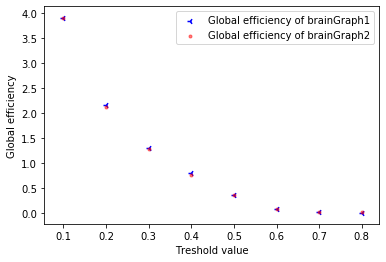

In [9]:
plt.figure()
plt.scatter(x_axis[1:],brain1_glob_eff[1:],c='b',marker="3",label="Global efficiency of brainGraph1")
plt.scatter(x_axis[1:],brain2_glob_eff[1:],c='r',marker=".",alpha=0.5,label="Global efficiency of brainGraph2")
plt.legend()
plt.xlabel("Treshold value")
plt.ylabel("Global efficiency")
plt.show()

#### Answer 2.4
The same plotting made fore the diffusion efficiency.

/home/alperen/anaconda3/envs/Keras/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


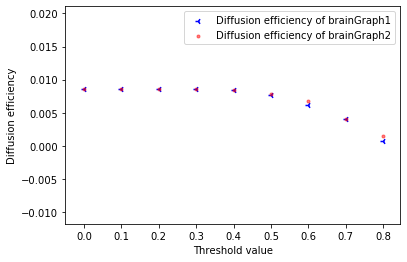

In [10]:
x_axis = np.arange(0,0.9,0.1)
brain1_dif_eff = [diffusionEfficiency(brain1*(brain1 > t)) for t in x_axis]
brain2_dif_eff = [diffusionEfficiency(brain2*(brain2 > t)) for t in x_axis]

plt.figure()
plt.scatter(x_axis,brain1_dif_eff,c='b',marker="3",label="Diffusion efficiency of brainGraph1")
plt.scatter(x_axis,brain2_dif_eff,c='r',marker=".",alpha=0.5,label="Diffusion efficiency of brainGraph2")
plt.xlabel("Threshold value")
plt.ylabel("Diffusion efficiency")
plt.legend()
plt.show()

#### Answer 2.5
From these two graphs in general both brain graphs have similar diffusion and global efficiency. 

#### Answer 2.6 
Morphospace shows the two braingraphs under different thresholded values.
X axis shows E_diff whereas Y axis denotes E_glob 

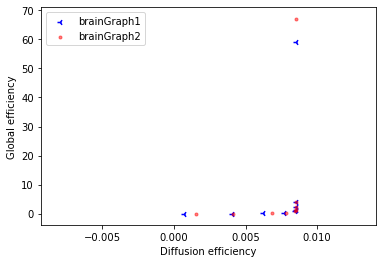

In [11]:
plt.figure()
plt.scatter(brain1_dif_eff,brain1_glob_eff,c='b',marker="3",label="brainGraph1")
plt.scatter(brain2_dif_eff,brain2_glob_eff,c='r',marker=".",alpha=0.5,label="brainGraph2")
plt.xlabel("Diffusion efficiency")
plt.ylabel("Global efficiency")
plt.legend()
plt.show()

Again outlier global efficiency values change the scalings of the axes therefore the morphospace below will show the values without that one outlier.

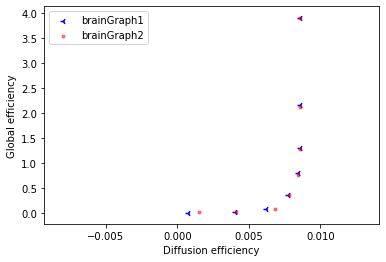

In [12]:
plt.figure()
plt.scatter(brain1_dif_eff[1:],brain1_glob_eff[1:],c='b',marker="3",label="brainGraph1")
plt.scatter(brain2_dif_eff[1:],brain2_glob_eff[1:],c='r',marker=".",alpha=0.5,label="brainGraph2")
plt.xlabel("Diffusion efficiency")
plt.ylabel("Global efficiency")
plt.legend()
plt.show()

#### Answer 2.7

We see that both graphs give close efficiency values in general but as we increase the treshold values we get faster decrease in the global efficiency then diffusion efficiency. From this finding we can say that shortest path between the nodes increase so much when we tresholded but it doesn't affect the information flow from hubs (which increase diffusion efficiency) as much as global efficiency. 

# Question 3

In [56]:
# Function takes W which is the matrix and t which will define the new t* by calculating t_star*t
# So if t = 2 then t_star*2  iterations will be made or if t=0.2 then t_star*0.2 iterations will be made.
# If t is none then t_star iterations will be made. 
def selfDiffuse(W,t=None):
    num_nodes = W.shape[0]
    epsilon = 1e-1
    c = 0.05
    
    D = np.zeros(W.shape)
    for i in range(num_nodes):
        D[i,i] = np.sum(W[i,:])
    D_inv = np.linalg.inv(D)
    W_t = W.copy()
    
    P = np.dot(D_inv,W_t)
    eigs, _ = np.linalg.eig(P)
    W_P_dot = np.dot(W,P)
    # As you can see t_star is estimated by using the method of the paper
    t_star = np.log(epsilon/((num_nodes-np.trace(P))*np.linalg.norm(W-W_P_dot-np.identity(W_P_dot.shape[0],dtype=np.int64))))
    t_star = t_star // np.log(eigs[1]-c).real
    t_star = int(t_star)
    if t != None:
        t_star *= t
    print("Estimated t* value is =",t_star)
    P = np.dot(D_inv,W_t)
    # Continue to iterate for smoothing until optimal t*
    for _ in range(t_star):
        
        W_t = np.dot(W_t,P)
        W_t = W_t + np.identity(W_t.shape[0])
        # Self normalization step
    W_t = np.dot(W_t,D_inv)
    
    return W_t

Diffusion of brain1 matrix
Estimated t* value is = 26


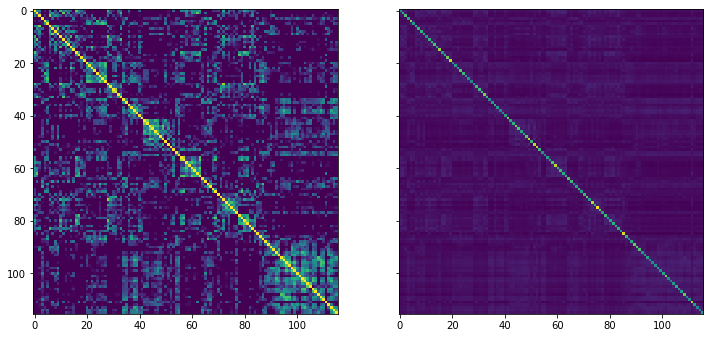

In [57]:
print("Diffusion of brain1 matrix")
diffused_brain1 = selfDiffuse(brain1)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 16))
ax[0].imshow(brain1)
ax[1].imshow(diffused_brain1)
plt.show()

Diffusion of brain2 matrix
Estimated t* value is = 27


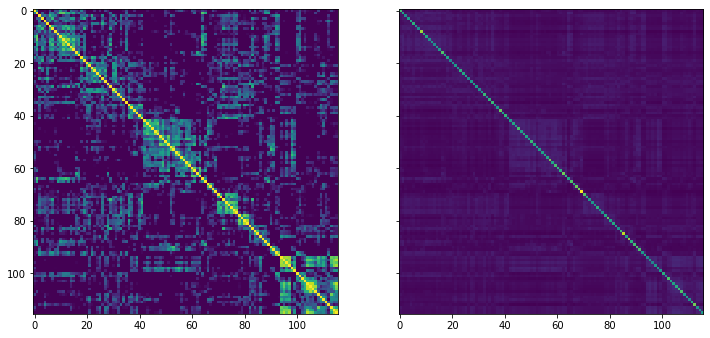

In [58]:
print("Diffusion of brain2 matrix")
diffused_brain2 = selfDiffuse(brain2)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 16))
ax[0].imshow(brain2)
ax[1].imshow(diffused_brain2)
plt.show()

In [16]:
# Image relative paths are given for segmentation task
img1_p = os.path.join("Exercise_3_data","image1.jpg")
img2_p = os.path.join("Exercise_3_data","image2.jpg")
# Computation for the big image resolutions take so much time
# For faster results decrease the downsampling resolution which describe new resolution of the images.
downsample_resolution = 55
img1 = Image.open(img1_p)
img1 = img1.resize((downsample_resolution,downsample_resolution))
img1 = np.asarray(img1)/255
img2 = Image.open(img2_p)
img2 = img2.resize((downsample_resolution,downsample_resolution))
img2 = np.asarray(img2)/255

Image 1


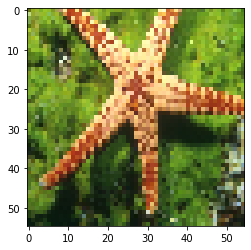

Image 2


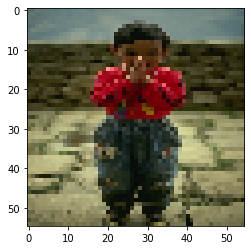

In [17]:
# Lets see our images 
print("Image 1")
plt.imshow(img1)
plt.show()
print("Image 2")
plt.imshow(img2)
plt.show()

#### Question 3.3
Normalized cut code is retrieved from this [GitHub repository](https://github.com/marktao99/python/blob/master/CVP/samples/ncut.py).

In [18]:
from scipy.cluster.vq import *
from sklearn.cluster import KMeans

def ncut_graph_matrix(im,sigma_d=1e2,sigma_g=1e-2):
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
    
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    if len(im.shape)==3:
        for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()
        vim = im.reshape((-1,3))
    else:
        im = im / im.max()
        vim = im.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = np.meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = np.zeros((N,N),'f')
    for i in range(N):
        for j in range(i,N):
            d = (x[i]-x[j])**2 + (y[i]-y[j])**2 
            W[i,j] = W[j,i] = np.exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * np.exp(-d/sigma_d)
    
    return W

def cluster(S,k,ndim):
    """ Spectral clustering from a similarity matrix."""
    
    # check for symmetry
    if np.sum(np.abs(S-S.T)) > 1e-10:
        print('not symmetric')
    
    # create Laplacian matrix
    rowsum = np.sum(np.abs(S),axis=0)
    D = np.diag(1 / np.sqrt(rowsum + 1e-6))
    L = np.dot(D,np.dot(S,D))
    
    # compute eigenvectors of L
    U,sigma,V = np.linalg.svd(L,full_matrices=False)
    
    # create feature vector from ndim first eigenvectors
    # by stacking eigenvectors as columns
    features = np.array(V[:ndim]).T

    # k-means
    features =whiten(features)
    centroids,distortion = kmeans(features,k)
    code,distance = vq(features,centroids)
        
    return code,V

Calculation of the ncut takes a while even with the downsampled images. It may take couple minutes (5 or more).

In [19]:
W_star1 = ncut_graph_matrix(img1.copy())
W_star2 = ncut_graph_matrix(img2.copy())

You can see the results for the normal cut.

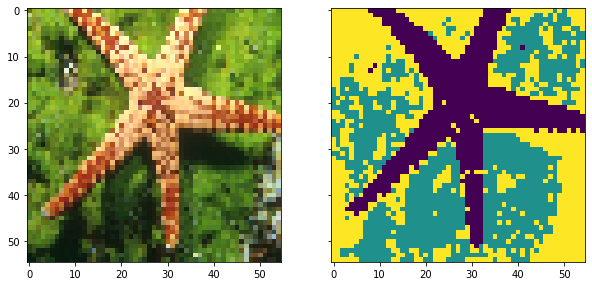

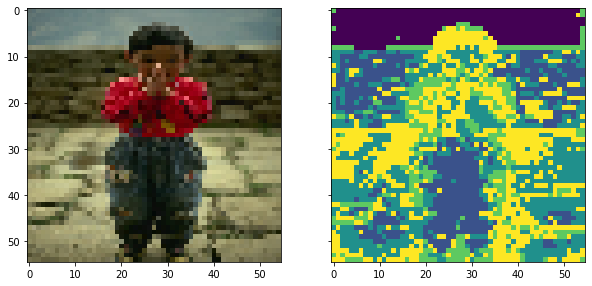

In [28]:
code, V = cluster(W_star1.T,k=3,ndim=2)
code.resize((img1.shape[0],img1.shape[1]))
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 12))
ax[0].imshow(img1)
ax[1].imshow(code)
plt.show()
code, V = cluster(W_star2.T,k=5,ndim=2)
code.resize((img2.shape[0],img2.shape[1]))
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 12))
ax[0].imshow(img2)
ax[1].imshow(code)
plt.show()


#### Question 3.4

For each image selfDiffuse function will be called but images are RGB and therefore we have 3-D matrices. I have tried with single channels but probably I have a mistake in the selfDiffuse therefore my segmentation results are wrong. 

Estimated t* value is = 5
not symmetric


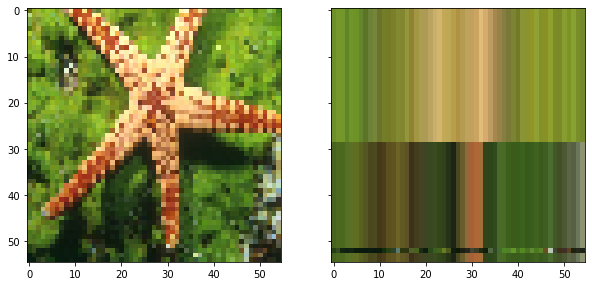

Estimated t* value is = 4
not symmetric


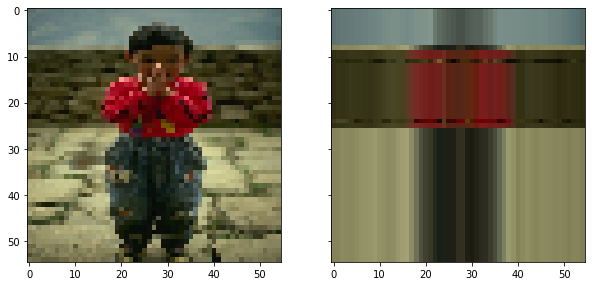

In [86]:
W_star1_selfDif = selfDiffuse(img1[:,:,0])
code, V = cluster(W_star1_selfDif.T,k=3,ndim=5)
V.resize((img1.shape[0],img1.shape[1]))
out1 = color.label2rgb(code, img1, kind='avg')
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 12))
ax[0].imshow(img1)
ax[1].imshow(out1)
plt.show()

W_star2_selfDif = selfDiffuse(img2[:,:,2])
code, V = cluster(W_star2_selfDif.T,k=5,ndim=3)
V.resize((img2.shape[0],img2.shape[1]))
out2 = color.label2rgb(code, img2, kind='avg')
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 12))
ax[0].imshow(img2)
ax[1].imshow(out2)
plt.show()